In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import xgboost as xgb

sns.set(style="whitegrid")

In [2]:
# URLs for UCI Adult dataset
TRAIN_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
TEST_URL  = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

# Column names from adult.names
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]


df_train = pd.read_csv(TRAIN_URL, header=None, names=columns, sep=",\s", na_values="?", engine="python")

df_test  = pd.read_csv(TEST_URL, header=0, names=columns, sep=",\s", na_values="?", engine="python", skiprows=1)

print("Train shape:", df_train.shape)
print("Test shape: ", df_test.shape)


Train shape: (32561, 15)
Test shape:  (16280, 15)


 Exploratory Data Analysis (EDA)

In [3]:
# Peek at data
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Missing values
df_train.isnull().sum()

,0
age,0
workclass,1836
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,1843
relationship,0
race,0
sex,0


Text(0.5, 1.0, 'Income Distribution in Training Set')

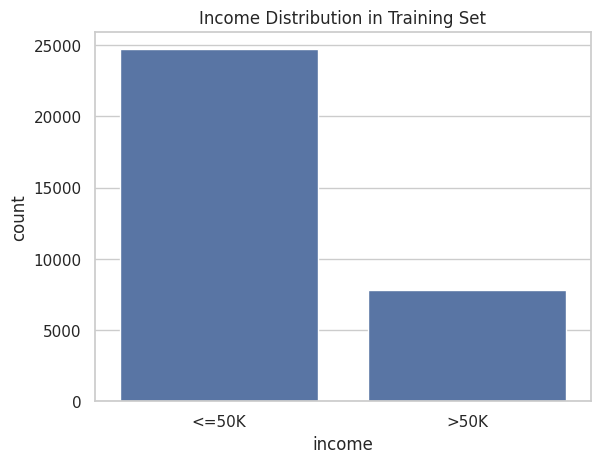

In [5]:
# Class distribution
sns.countplot(x="income", data=df_train)
plt.title("Income Distribution in Training Set")

Handling Missing Values

In [9]:
# Separate feature types
num_feats = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]
cat_feats = [c for c in columns if c not in num_feats + ["income"]]

# Pipelines
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # Changed sparse to False
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_feats),
    ("cat", cat_pipeline, cat_feats)
])

Train–Test Split

In [10]:
X_train = df_train.drop("income", axis=1)
y_train = df_train["income"].apply(lambda x: 1 if x.strip()==">50K" else 0)

X_test  = df_test.drop("income", axis=1)
y_test  = df_test["income"].apply(lambda x: 1 if x.strip()==">50K." else 0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(32561, 14) (32561,) (16280, 14) (16280,)


Baseline Model Training & Evaluation

In [11]:
def evaluate_model(model, X_tr, y_tr, X_te, y_te):
    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", model)
    ])
    pipe.fit(X_tr, y_tr)
    preds = pipe.predict(X_te)
    return {
        "accuracy": accuracy_score(y_te, preds),
        "precision": precision_score(y_te, preds),
        "recall": recall_score(y_te, preds),
        "f1": f1_score(y_te, preds)
    }

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "NaiveBayes": GaussianNB()
}

results = {}
for name, mdl in models.items():
    results[name] = evaluate_model(mdl, X_train, y_train, X_test, y_test)

pd.DataFrame(results).T


,accuracy,precision,recall,f1
LogisticRegression,0.850676,0.728152,0.587103,0.650065
RandomForest,0.850614,0.717672,0.606084,0.657175
SVM,0.858170,0.759016,0.585543,0.661089
KNN,0.833292,0.663868,0.596204,0.628219
GradientBoosting,0.868857,0.791681,0.603744,0.685057
NaiveBayes,0.551106,0.337830,0.937598,0.496694


Hyperparameter Tuning

In [12]:
# Grid SearchCV for Random Forest
rf_params = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 10, 20],
    "clf__min_samples_split": [2, 5, 10]
}

rf_grid = GridSearchCV(
    Pipeline([("prep", preprocessor), ("clf", RandomForestClassifier())]),
    rf_params, cv=5, scoring="f1", n_jobs=-1
)
rf_grid.fit(X_train, y_train)
print("Best RF params:", rf_grid.best_params_)
print("Best RF F1:", rf_grid.best_score_)


Best RF params: {'clf__max_depth': None, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}
Best RF F1: 0.6868402896101713


In [14]:
best_rf = rf_grid.best_estimator_
y_pred = best_rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["<=50K"," >50K"]))


              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91     12434
        >50K       0.75      0.61      0.67      3846

    accuracy                           0.86     16280
   macro avg       0.82      0.77      0.79     16280
weighted avg       0.85      0.86      0.85     16280



Text(0.5, 1.0, 'Confusion Matrix - Best Random Forest')

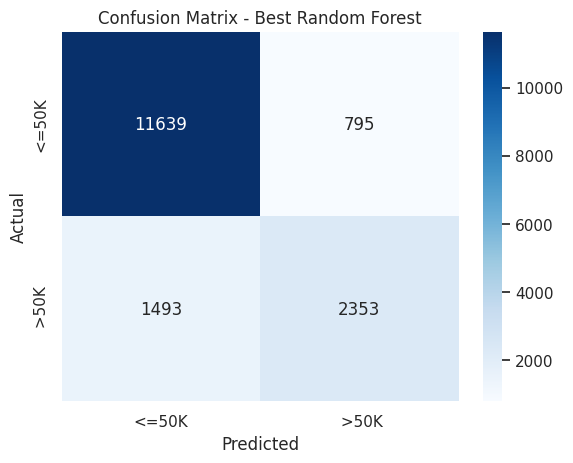

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["<=50K"," >50K"], yticklabels=["<=50K"," >50K"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Best Random Forest")


Text(0, 0.5, 'Feature')

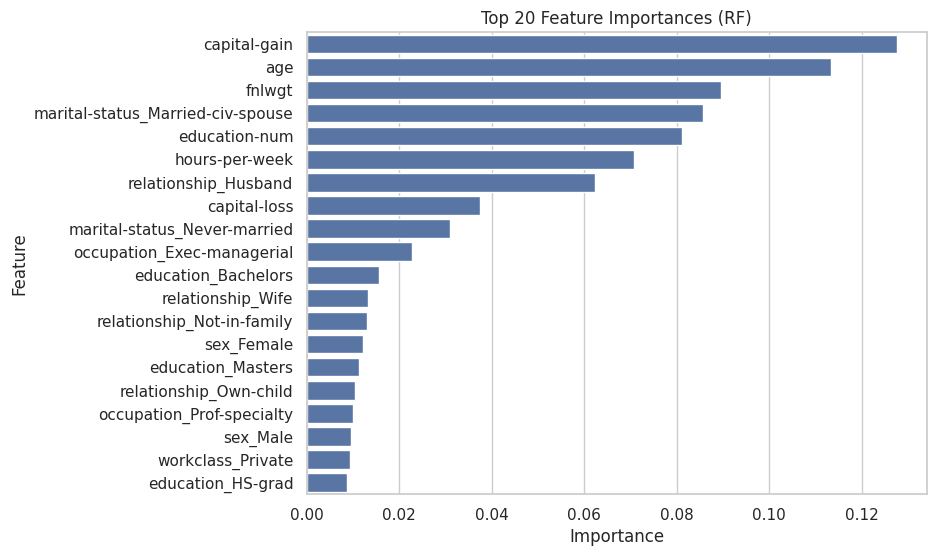

In [16]:
# Extract feature names after preprocessing
ohe_feats = best_rf.named_steps["prep"].named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(cat_feats)
all_feats = np.concatenate([num_feats, ohe_feats])

importances = best_rf.named_steps["clf"].feature_importances_
feat_imp = pd.Series(importances, index=all_feats).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 20 Feature Importances (RF)")
plt.xlabel("Importance")
plt.ylabel("Feature")
